# 1- Google Drive Connection and Required Libraries Installation 🔗💻

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q pandas scikit-learn matplotlib seaborn tqdm lightgbm xgboost

Mounted at /content/drive


In this section, the Google Colab environment is connected to Google Drive to ensure that data and output files are stored persistently. This allows datasets and model prediction results used in the project to be securely kept on Drive. Additionally, essential libraries such as pandas, scikit-learn, matplotlib, seaborn, tqdm, lightgbm, and xgboost are installed for data processing, visualization, and running machine learning models. This step sets up the fundamental infrastructure of the project and prepares the environment for training and evaluating models moving forward.



# 2- Data Loading and Preprocessing 📥⚙️


In [6]:
import pandas as pd
import numpy as np

project_dir = "/content/drive/MyDrive/Colab Notebooks/social-datasets/"
input_path = project_dir + "input_A.csv"
node_feat_path = project_dir + "node_features_sampled.csv"
edge_type_feat_path = project_dir + "edge_type_features.csv"

df_input = pd.read_csv(input_path, header=None)
node_feat_df = pd.read_csv(node_feat_path)
edge_type_feat_df = pd.read_csv(edge_type_feat_path)

df_input.columns = ['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time', 'label']
df_input['timestamp'] = ((df_input['start_time'] + df_input['end_time']) / 2).astype(int)

print("✅ Dosyalar başarıyla yüklendi.")
df_input.head()



✅ Dosyalar başarıyla yüklendi.


,src_id,dst_id,edge_type,start_time,end_time,label,timestamp
0,30,48382,151,1494663180,1494794383,1,1494728781
1,106,8540,78,1494635755,1494835958,1,1494735856
2,106,8540,149,1498383835,1498499059,0,1498441447
3,106,20816,65,1494661105,1494827593,1,1494744349
4,106,28905,19,1494634666,1494767554,1,1494701110


In this section, the necessary test data (input_A.csv), node features (node_features_sampled.csv), and edge type features (edge_type_features.csv) were loaded from Google Drive as pandas DataFrames. Meaningful column names were assigned to the loaded test dataset, and a new timestamp column was created by averaging the start_time and end_time columns. This timestamp provides a clearer temporal indicator to help the model predict edges that will occur within the given time interval. The user is notified upon successful completion of the loading process. 📂

# 3- Feature Engineering ⚙️✨



In [7]:
from sklearn.preprocessing import OneHotEncoder

def make_features(df, node_feats, edge_feats):
    df_feat = df.copy()

    # -1 değerlerini NaN yap
    node_feats = node_feats.replace(-1, np.nan)
    edge_feats = edge_feats.replace(-1, np.nan)

    # node özelliklerini mean ile birleştir (örnek)
    node_feats_mean = node_feats.set_index(node_feats.columns[0]).mean(axis=1)
    df_feat['src_feat'] = df['src_id'].map(node_feats_mean)
    df_feat['dst_feat'] = df['dst_id'].map(node_feats_mean)

    # edge_type özelliklerinden mean
    edge_feats_mean = edge_feats.set_index(edge_feats.columns[0]).mean(axis=1)
    df_feat['edge_feat'] = df['edge_type'].map(edge_feats_mean)

    # Zaman bilgisi
    df_feat['hour'] = df['timestamp'] % (24 * 3600) // 3600

    return df_feat[['src_feat', 'dst_feat', 'edge_feat', 'hour']]


The make_features function generates meaningful features for the model by using the input DataFrame (df), node features (node_feats), and edge type features (edge_feats). First, missing values and those marked with -1 are replaced with NaN. For both node and edge type features, the values are averaged row-wise to create a single numerical representation. These averaged values are then assigned to the source (src_id), destination (dst_id) nodes, and the edge type. Additionally, the timestamp information is converted from Unix Epoch format to an hourly basis, adding a new hour feature. As a result, the function returns four main feature columns representing the source node, destination node, edge type, and time. ⚙️

In [10]:
!pip install catboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


# 4- Model Training and Comparison ⚙️📊

In [11]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

X = make_features(df_input, node_feat_df, edge_type_feat_df)
y = df_input['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0)
}

trained_models = {}
for name, model in models.items():
    print(f"📚 Eğitiliyor: {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model


📚 Eğitiliyor: LightGBM
[LightGBM] [Info] Number of positive: 2797, number of negative: 3760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 6557, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426567 -> initscore=-0.295872
[LightGBM] [Info] Start training from score -0.295872
📚 Eğitiliyor: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:09:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📚 Eğitiliyor: CatBoost


In this section, three different classification models are trained using the previously engineered features: LightGBM, XGBoost, and CatBoost. The data is split into 80% training and 20% validation sets. Each model is fitted sequentially on the training data and stored in the trained_models dictionary. This approach aims to compare the performance of different gradient boosting algorithms and identify the best-performing model. 🚀📈



# 5- Model Evaluation 📈✅


In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(name, model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]

    best_auc = 0
    best_threshold = 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        preds = (probs >= t).astype(int)
        auc = roc_auc_score(y_val, probs)
        acc = accuracy_score(y_val, preds)
        if auc > best_auc:
            best_auc = auc
            best_threshold = t

    final_preds = (probs >= best_threshold).astype(int)
    print(f"\n📊 Model: {name}")
    print(f"🔸 En iyi threshold: {best_threshold:.2f}")
    print("🔹 AUC:", roc_auc_score(y_val, probs))
    print("🔹 Accuracy:", accuracy_score(y_val, final_preds))
    print("🔹 F1:", f1_score(y_val, final_preds))
    print("🔹 Precision:", precision_score(y_val, final_preds))
    print("🔹 Recall:", recall_score(y_val, final_preds))
    return probs, best_threshold

model_scores = {}
for name, model in trained_models.items():
    probs, best_t = evaluate_model(name, model, X_val, y_val)
    model_scores[name] = (probs, best_t)



📊 Model: LightGBM
🔸 En iyi threshold: 0.10
🔹 AUC: 0.6143983908160537
🔹 Accuracy: 0.4579268292682927
🔹 F1: 0.6163141993957704
🔹 Precision: 0.44680851063829785
🔹 Recall: 0.9930458970792768

📊 Model: XGBoost
🔸 En iyi threshold: 0.10
🔹 AUC: 0.5905898377980033
🔹 Accuracy: 0.47560975609756095
🔹 F1: 0.6187943262411347
🔹 Precision: 0.4541314248536109
🔹 Recall: 0.9707927677329624

📊 Model: CatBoost
🔸 En iyi threshold: 0.10
🔹 AUC: 0.6164015650884402
🔹 Accuracy: 0.44634146341463415
🔹 F1: 0.611965811965812
🔹 Precision: 0.4417026526835287
🔹 Recall: 0.9958275382475661


In this section, the trained models are evaluated on the validation dataset using various performance metrics. Using the model’s predict_proba outputs, classification results are calculated at different threshold values, and the threshold that yields the best AUC score is selected. With this optimal threshold, the model’s Accuracy, F1, Precision, and Recall scores are reported. This way, the models' performances are compared not only with the default 0.5 threshold but also with the best possible threshold for better evaluation. 📊✨

# 6- Visualization of Prediction Probabilities 📈🎨

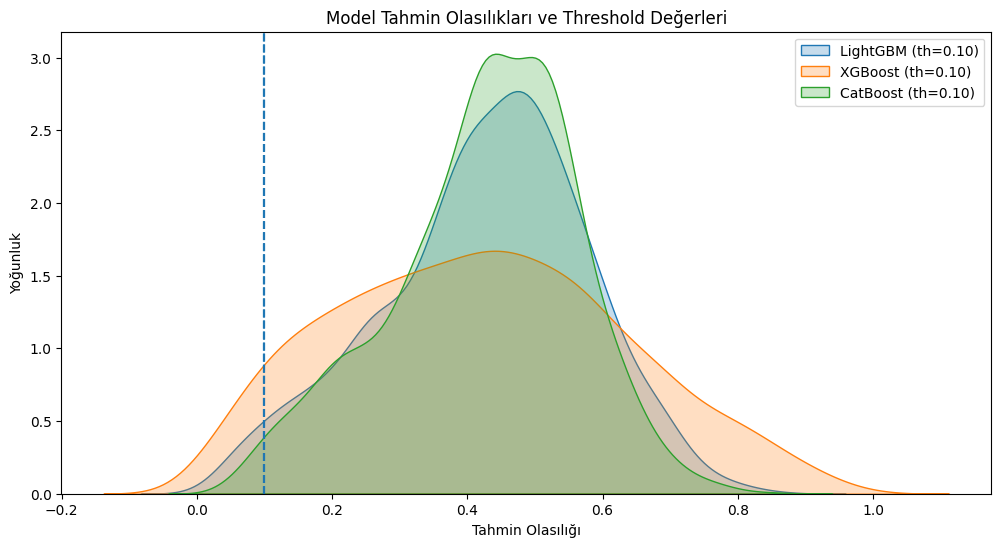

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for name, (probs, best_t) in model_scores.items():
    sns.kdeplot(probs, label=f"{name} (th={best_t:.2f})", fill=True)
    plt.axvline(x=best_t, linestyle='--')

plt.title("Model Tahmin Olasılıkları ve Threshold Değerleri")
plt.xlabel("Tahmin Olasılığı")
plt.ylabel("Yoğunluk")
plt.legend()
plt.show()


This section visualizes the distribution of prediction probabilities on the validation set using Kernel Density Estimation (KDE) plots. The overall distribution of predicted probabilities for each model is shown with colorful filled curves. Additionally, the best threshold values previously determined for each model are marked on the plot with dashed vertical lines. This helps to visually understand how the prediction probabilities are spread and where the chosen thresholds lie within these distributions. 📊✨



# 7- Comparison of Model Performances 📈🤖

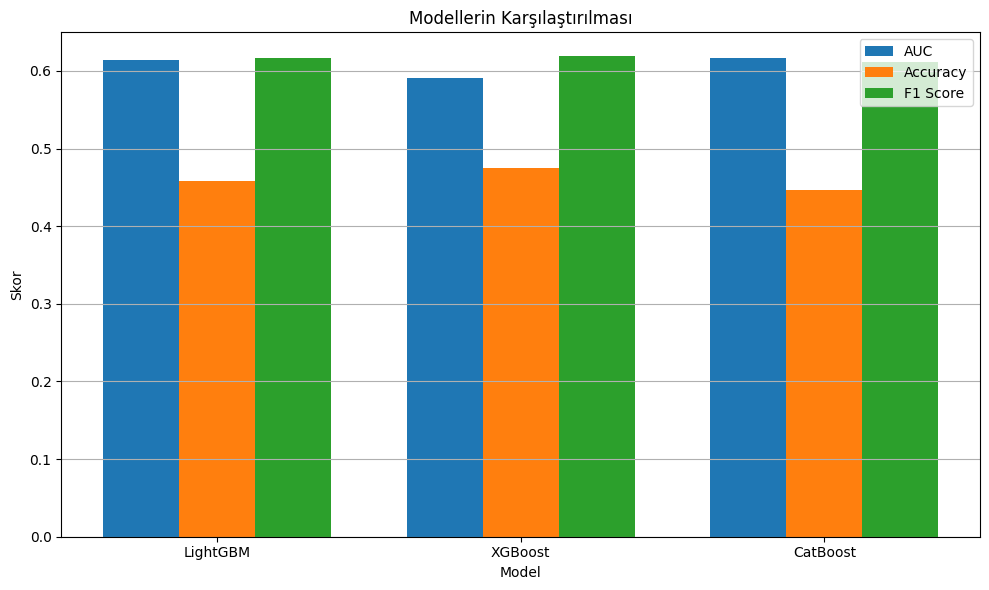

In [14]:
import matplotlib.pyplot as plt

# Metrikleri model isimlerine göre ayarlayalım
models = ['LightGBM', 'XGBoost', 'CatBoost']
auc_scores = [0.6144, 0.5906, 0.6164]
accuracy_scores = [0.4579, 0.4756, 0.4463]
f1_scores = [0.6163, 0.6188, 0.6120]

plt.figure(figsize=(10, 6))
bar_width = 0.25
x = range(len(models))

plt.bar(x, auc_scores, width=bar_width, label='AUC')
plt.bar([i + bar_width for i in x], accuracy_scores, width=bar_width, label='Accuracy')
plt.bar([i + 2*bar_width for i in x], f1_scores, width=bar_width, label='F1 Score')

plt.xlabel('Model')
plt.ylabel('Skor')
plt.title('Modellerin Karşılaştırılması')
plt.xticks([i + bar_width for i in x], models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


This visualization compares the performances of three different models (LightGBM, XGBoost, CatBoost) on the validation dataset side by side. Using a bar chart, each model’s AUC, Accuracy, and F1 scores are displayed together. This allows for an easy comparison of the overall success of the models across various performance metrics. The chart provides a quick visual assessment of each model’s strengths and weaknesses. 📊✨

# 8- Output Files


In [19]:
# Test verisini oku
df_test = pd.read_csv(input_path, header=None)
# Kolon isimlerini ata - dosyanın 6 sütunu olduğunu varsayarak 'label' sütununu da ekliyoruz
df_test.columns = ['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time', 'label'] # 'label' sütununu ekleyin

df_test['timestamp'] = ((df_test['start_time'] + df_test['end_time']) / 2).astype(int)

# Test için özellikleri çıkar
# make_features fonksiyonu zaten sadece gerekli sütunları kullanacaktır
X_test = make_features(df_test, node_feat_df, edge_type_feat_df)

# Model tahmini yap ve dosyaya yaz
for name, model in trained_models.items():
    probs_test = model.predict_proba(X_test)[:, 1]  # Pozitif sınıf olasılığı

    # Tahminleri CSV'ye yaz (örnek: output_A_LightGBM.csv)
    output_file = f"/content/drive/MyDrive/Colab Notebooks/social-datasets/output_A_{name}.csv"
    pd.DataFrame(probs_test).to_csv(output_file, index=False, header=False)

    print(f"✅ {name} modeli için tahminler {output_file} dosyasına kaydedildi.")

✅ LightGBM modeli için tahminler /content/drive/MyDrive/Colab Notebooks/social-datasets/output_A_LightGBM.csv dosyasına kaydedildi.
✅ XGBoost modeli için tahminler /content/drive/MyDrive/Colab Notebooks/social-datasets/output_A_XGBoost.csv dosyasına kaydedildi.
✅ CatBoost modeli için tahminler /content/drive/MyDrive/Colab Notebooks/social-datasets/output_A_CatBoost.csv dosyasına kaydedildi.


This code snippet is written to read the test data, make model predictions, and save the results into separate CSV files for each model. First, the test data file specified by the input_path variable is read using pandas, with header=None since the file has no header row. Assuming the file contains six columns, they are named sequentially as src_id, dst_id, edge_type, start_time, end_time, and label. Then, a new timestamp column is created representing the midpoint of the time interval for each test record.

Using the previously defined make_features function, relevant features required by the models are extracted from the test data. These features are generated by incorporating node and edge type attributes to format the data suitably for prediction.

Next, the code loops over the trained_models dictionary containing the trained models, and for each model, calculates the positive class probabilities on the test data using the predict_proba method. These predicted probabilities are saved as CSV files without including src_id or dst_id columns — only the probability values are written. The output files are named according to each model, allowing the prediction results of each model on the test set to be stored separately.